In [1]:
import json
import warnings

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, StandardScaler
from torch.utils.data import DataLoader, Dataset

from models.main import get_model, train_model
from preprocessing import PreProcessing
from utils import (
    calculate_velocity_acceleration,
    calculate_velocity_direction,
    get_frame_data,
    process_event_data, 
    plot_confusion_matrix, 
    plot_accuracy_history,
    calculate_player_ball_distances,
    track_closest_players,
    get_n_smallest_indices_sorted
)

In [2]:
BALL_POSSESSION_SPEED = 0.05 #Temp parameter

In [3]:
game_1_pre = PreProcessing()
game_1_data = game_1_pre.load_and_process_data(
    data_home="data/Sample_Game_1/Sample_Game_1_RawTrackingData_Home_Team.csv", 
    data_away="data/Sample_Game_1/Sample_Game_1_RawTrackingData_Away_Team.csv", 
    add_ball_data=True, 
    remove_ball_nan=False
)

In [4]:
game_2_pre = PreProcessing()
game_2_data = game_2_pre.load_and_process_data(
    data_home="data/Sample_Game_2/Sample_Game_2_RawTrackingData_Home_Team.csv", 
    data_away="data/Sample_Game_2/Sample_Game_2_RawTrackingData_Away_Team.csv", 
    add_ball_data=True, 
    remove_ball_nan=False
)

In [5]:
game_1_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1.0,1.0,0.04,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.45472,0.38709
2,1.0,2.0,0.08,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.49645,0.40656
3,1.0,3.0,0.12,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.53716,0.42556
4,1.0,4.0,0.16,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,...,0.55236,0.43313,0.50034,0.94391,0.43644,0.05038,0.37756,0.27473,0.55346,0.42231
5,1.0,5.0,0.20,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,...,0.55202,0.43311,0.50017,0.94434,0.43580,0.04977,0.37663,0.27543,0.55512,0.40570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,2.0,145002.0,5800.08,0.90614,0.45355,0.30044,0.68311,0.34157,0.64598,0.31228,...,0.10317,0.81976,0.19836,0.45137,0.29416,0.48874,0.35600,0.55371,0.03058,0.99726
145003,2.0,145003.0,5800.12,0.90550,0.45355,0.30044,0.68311,0.34127,0.64583,0.31230,...,0.10319,0.81960,0.19831,0.45182,0.29373,0.48836,0.35583,0.55283,0.03058,0.99726
145004,2.0,145004.0,5800.16,0.90492,0.45355,0.30044,0.68311,0.34089,0.64569,0.31214,...,0.10285,0.81944,0.19805,0.45200,0.29331,0.48800,0.35561,0.55254,0.03058,0.99726
145005,2.0,145005.0,5800.20,0.90456,0.45356,0.30044,0.68311,0.34056,0.64552,0.31171,...,0.10231,0.81944,0.19766,0.45237,0.29272,0.48789,0.35532,0.55243,0.03058,0.99726


In [6]:
game_2_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1.0,1.0,0.04,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
2,1.0,2.0,0.08,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
3,1.0,3.0,0.12,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
4,1.0,4.0,0.16,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
5,1.0,5.0,0.20,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,2.0,141152.0,5646.08,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46751,1.05000,0.44966,0.41572,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891
141153,2.0,141153.0,5646.12,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46790,1.05000,0.44983,0.41550,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891
141154,2.0,141154.0,5646.16,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46818,1.05000,0.44997,0.41485,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891
141155,2.0,141155.0,5646.20,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46855,1.05000,0.45017,0.41515,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891


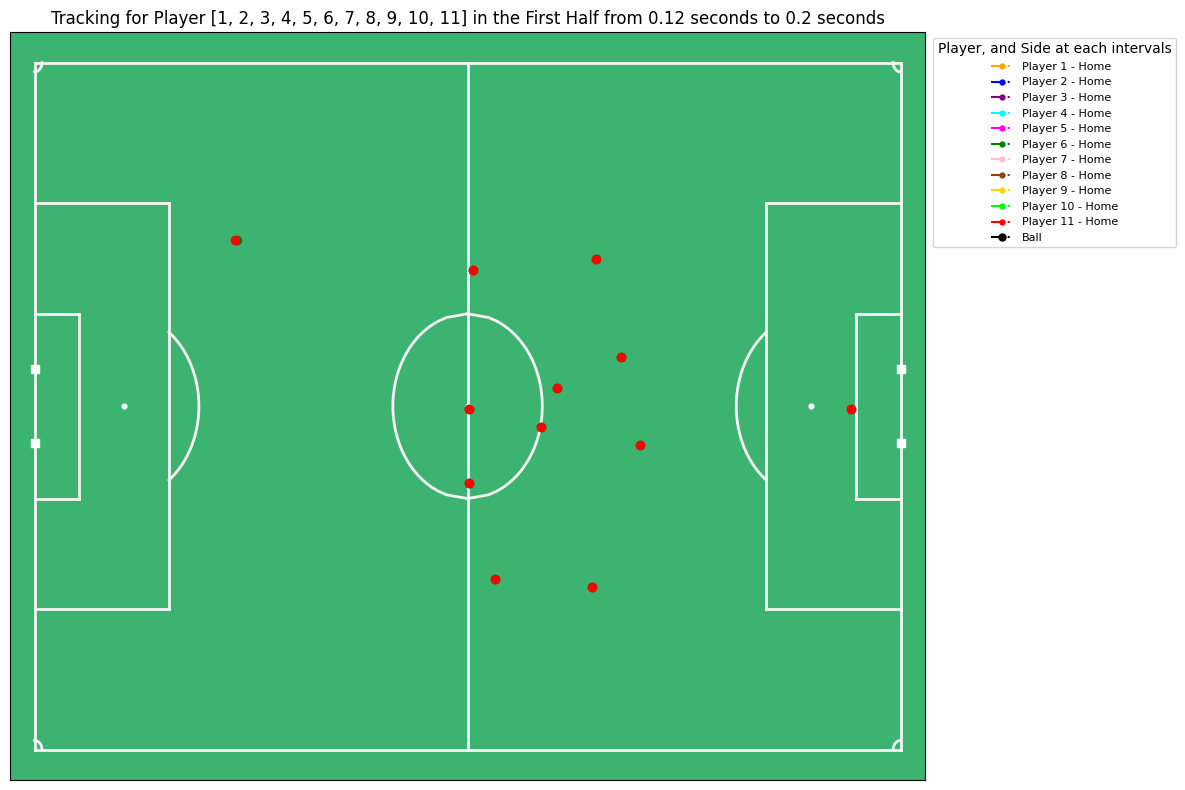

In [7]:
game_2_pre.player_visualization(game_2_data.iloc[2:5], players=[1,2,3,4,5,6,7,8,9,10,11], sides=["Home"]*11, plot_ball=True)

# Tracking players closest to the ball using frames

In [8]:
vel_acc_game_1_data = calculate_velocity_acceleration(game_1_data)
vel_acc_game_2_data = calculate_velocity_acceleration(game_2_data)

In [9]:
vel_acc_game_1_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,P_21_velocity,P_21_acceleration,P_22_velocity,P_22_acceleration,P_23_velocity,P_23_acceleration,P_24_velocity,P_24_acceleration,Ball_velocity,Ball_acceleration
1,1.0,1.0,0.04,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,2.0,0.08,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,1.151215,NaN
3,1.0,3.0,0.12,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.123138,-0.701914
4,1.0,4.0,0.16,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,...,0.011138,0.278458,0.019121,0.478033,0.015201,0.380019,0.029611,0.740275,0.415521,-17.690434
5,1.0,5.0,0.20,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,...,0.008515,-0.065591,0.011560,-0.189042,0.022103,0.172568,0.029100,-0.012774,0.417319,0.044937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,2.0,145002.0,5800.08,0.90614,0.45355,0.30044,0.68311,0.34157,0.64598,0.31228,...,0.010198,0.098326,0.002704,0.017604,0.013613,0.028951,0.017509,0.062515,0.000000,0.000000
145003,2.0,145003.0,5800.12,0.90550,0.45355,0.30044,0.68311,0.34127,0.64583,0.31230,...,0.004031,-0.154173,0.011319,0.215377,0.014346,0.018330,0.022407,0.122446,0.000000,0.000000
145004,2.0,145004.0,5800.16,0.90492,0.45355,0.30044,0.68311,0.34089,0.64569,0.31214,...,0.009394,0.134075,0.007906,-0.085338,0.013829,-0.012921,0.009100,-0.332665,0.000000,0.000000
145005,2.0,145005.0,5800.20,0.90456,0.45356,0.30044,0.68311,0.34056,0.64552,0.31171,...,0.013500,0.102646,0.013440,0.138350,0.015004,0.029371,0.007754,-0.033653,0.000000,0.000000


In [10]:
game_1_players, game_1_ball, game_1_vel_acc = vel_acc_game_1_data.loc[:, "Home-Player11-x":"Away-Player24-y"], vel_acc_game_1_data.loc[:, "Ball-x":"Ball-y"], vel_acc_game_1_data.loc[:, "P_11_velocity":]
game_2_players, game_2_ball, game_2_vel_acc = vel_acc_game_2_data.loc[:, "Home-Player11-x":"Away-Player24-y"], vel_acc_game_2_data.loc[:, "Ball-x":"Ball-y"], vel_acc_game_2_data.loc[:, "P_11_velocity":]

assert game_1_players.shape[0] == game_1_ball.shape[0] == game_1_vel_acc.shape[0]
assert game_2_players.shape[0] == game_2_ball.shape[0] == game_2_vel_acc.shape[0]

In [11]:
game_1_vel_acc

,P_11_velocity,P_11_acceleration,P_1_velocity,P_1_acceleration,P_2_velocity,P_2_acceleration,P_3_velocity,P_3_acceleration,P_4_velocity,P_4_acceleration,...,P_21_velocity,P_21_acceleration,P_22_velocity,P_22_acceleration,P_23_velocity,P_23_acceleration,P_24_velocity,P_24_acceleration,Ball_velocity,Ball_acceleration
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.003500,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,...,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,1.151215,NaN
3,0.004500,0.025000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.123138,-0.701914
4,0.001750,-0.068750,0.006619,0.165478,0.031445,0.786135,0.007558,0.188953,0.005397,0.134919,...,0.011138,0.278458,0.019121,0.478033,0.015201,0.380019,0.029611,0.740275,0.415521,-17.690434
5,0.002000,0.006250,0.013530,0.172774,0.009451,-0.549872,0.006576,-0.024541,0.020555,0.378951,...,0.008515,-0.065591,0.011560,-0.189042,0.022103,0.172568,0.029100,-0.012774,0.417319,0.044937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,0.020239,0.033536,0.000000,0.000000,0.006915,-0.034893,0.001581,0.030690,0.000000,0.000000,...,0.010198,0.098326,0.002704,0.017604,0.013613,0.028951,0.017509,0.062515,0.000000,0.000000
145003,0.016000,-0.105980,0.000000,0.000000,0.008385,0.036765,0.004031,0.061250,0.000000,0.000000,...,0.004031,-0.154173,0.011319,0.215377,0.014346,0.018330,0.022407,0.122446,0.000000,0.000000
145004,0.014500,-0.037500,0.000000,0.000000,0.010124,0.043474,0.008062,0.100778,0.000000,0.000000,...,0.009394,0.134075,0.007906,-0.085338,0.013829,-0.012921,0.009100,-0.332665,0.000000,0.000000
145005,0.009003,-0.137413,0.000000,0.000000,0.009280,-0.021097,0.013551,0.137214,0.000000,0.000000,...,0.013500,0.102646,0.013440,0.138350,0.015004,0.029371,0.007754,-0.033653,0.000000,0.000000


In [12]:
game_1_result = calculate_player_ball_distances(
    game_data=game_1_data,
    player_data=game_1_players,
    ball_data=game_1_ball
)
game_2_result = calculate_player_ball_distances(
    game_data=game_2_data,
    player_data=game_2_players,
    ball_data=game_2_ball
)

In [13]:
game_1_result

,Time [s],Home-Player11,Home-Player1,Home-Player2,Home-Player3,Home-Player4,Home-Player5,Home-Player6,Home-Player7,Home-Player8,...,Away-Player15,Away-Player16,Away-Player17,Away-Player18,Away-Player19,Away-Player20,Away-Player21,Away-Player22,Away-Player23,Away-Player24
1,0.04,0.463795,0.295416,0.155454,0.148886,0.219595,0.341617,0.098830,0.088441,0.175352,...,0.220884,0.235846,0.436262,0.232928,0.000000,0.309003,0.107827,0.558025,0.337539,0.136614
2,0.08,0.501257,0.299551,0.179323,0.194075,0.261277,0.330581,0.107148,0.132807,0.199417,...,0.217031,0.190031,0.399390,0.226727,0.046049,0.278446,0.061778,0.536677,0.361474,0.177678
3,0.12,0.539023,0.310186,0.209852,0.238478,0.303165,0.325775,0.131295,0.176923,0.229466,...,0.222589,0.145477,0.365426,0.229583,0.090974,0.253186,0.016853,0.518945,0.388685,0.219656
4,0.16,0.555507,0.323936,0.226885,0.252990,0.312891,0.335267,0.147990,0.188744,0.234062,...,0.215733,0.131024,0.363269,0.241644,0.104642,0.255527,0.010876,0.524298,0.389905,0.229610
5,0.20,0.559113,0.336918,0.234244,0.250761,0.303846,0.350554,0.156768,0.182844,0.220835,...,0.197277,0.135839,0.378605,0.255965,0.102534,0.272252,0.027585,0.541436,0.375398,0.220973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,5800.08,1.030643,0.414143,0.469161,0.427928,0.108863,0.458256,0.459833,0.506856,0.217931,...,0.453870,0.458256,0.100171,0.287968,0.264367,0.450826,0.191770,0.571092,0.572771,0.550123
145003,5800.12,1.030100,0.414143,0.469075,0.427821,0.108863,0.457754,0.459853,0.506856,0.217704,...,0.454683,0.457754,0.100171,0.287968,0.264367,0.451005,0.191925,0.570647,0.572911,0.550732
145004,5800.16,1.029607,0.414143,0.468928,0.427927,0.108863,0.457372,0.459966,0.506856,0.217345,...,0.454959,0.457372,0.100171,0.287968,0.264367,0.451111,0.191945,0.570399,0.573038,0.550836
145005,5800.20,1.029296,0.414143,0.468838,0.427892,0.108863,0.456586,0.460186,0.506856,0.216806,...,0.455336,0.456586,0.100171,0.287968,0.264367,0.452243,0.191742,0.569931,0.572866,0.550754


In [14]:
game_2_result

,Time [s],Home-Player11,Home-Player1,Home-Player2,Home-Player3,Home-Player4,Home-Player5,Home-Player6,Home-Player7,Home-Player8,...,Away-Player15,Away-Player16,Away-Player17,Away-Player18,Away-Player19,Away-Player20,Away-Player21,Away-Player22,Away-Player23,Away-Player24
1,0.04,0.440590,0.262111,0.191014,0.203496,0.294844,0.363726,0.104851,0.087024,0.248831,...,0.359238,0.200660,0.213021,0.236965,0.409932,0.108727,0.202358,0.526400,0.002343,0.141593
2,0.08,0.440590,0.262111,0.191014,0.203496,0.294844,0.363726,0.104851,0.087024,0.248831,...,0.359238,0.200660,0.213021,0.236965,0.409932,0.108727,0.202358,0.526400,0.002343,0.141593
3,0.12,0.440590,0.262111,0.191014,0.203496,0.294844,0.363726,0.104851,0.087024,0.248831,...,0.359238,0.200660,0.213021,0.236965,0.409932,0.108727,0.202358,0.526400,0.002343,0.141593
4,0.16,0.440590,0.262111,0.191014,0.203496,0.294844,0.364348,0.104851,0.087024,0.248831,...,0.359512,0.200660,0.213021,0.236965,0.409932,0.108727,0.202358,0.526400,0.002343,0.141593
5,0.20,0.440590,0.262111,0.191014,0.203496,0.294844,0.364963,0.104851,0.087024,0.248831,...,0.359768,0.200660,0.213021,0.236965,0.409932,0.108727,0.202358,0.526400,0.002343,0.141593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,5646.08,0.651304,0.194034,0.488442,0.386535,0.183404,0.118986,0.603386,0.602958,0.989591,...,0.081458,0.493244,0.641833,0.649969,0.583007,0.450188,1.090450,0.456393,0.672318,0.169162
141153,5646.12,0.651304,0.194034,0.488442,0.386535,0.183404,0.118986,0.603189,0.602958,0.990306,...,0.081458,0.492950,0.642163,0.649860,0.583427,0.450188,1.090471,0.456189,0.672318,0.169162
141154,5646.16,0.651304,0.194034,0.488442,0.386535,0.183404,0.118986,0.602523,0.602958,0.991150,...,0.081458,0.492180,0.642544,0.650310,0.583837,0.450188,1.090486,0.455554,0.672318,0.169162
141155,5646.20,0.651304,0.194034,0.488442,0.386535,0.183404,0.118986,0.601309,0.602958,0.991955,...,0.081458,0.489952,0.642961,0.650757,0.584248,0.450188,1.090506,0.455871,0.672318,0.169162


In [15]:
idx = game_1_result.min(axis=1).round(4)
game_1_closest_to_ball = get_n_smallest_indices_sorted(game_1_result.iloc[:, 1:], 5)

idx = game_2_result.min(axis=1).round(4)
game_2_closest_to_ball = get_n_smallest_indices_sorted(game_2_result.iloc[:, 1:], 5)
# print("\n".join(f"{i} - {ply} - {dis}" for i, ply, dis in zip(result.index, game_2_closest_to_ball, idx)))

In [16]:
game_1_closest_to_ball

,0,1,2,3,4
1,Away-Player19,Home-Player9,Home-Player7,Home-Player6,Home-Player10
2,Home-Player9,Away-Player19,Home-Player10,Away-Player21,Home-Player6
3,Home-Player10,Away-Player21,Home-Player9,Away-Player19,Home-Player6
4,Home-Player10,Away-Player21,Home-Player9,Away-Player19,Away-Player16
5,Home-Player10,Away-Player21,Home-Player9,Away-Player19,Away-Player16
...,...,...,...,...,...
145002,Away-Player17,Home-Player4,Away-Player21,Home-Player8,Away-Player19
145003,Away-Player17,Home-Player4,Away-Player21,Home-Player8,Away-Player19
145004,Away-Player17,Home-Player4,Away-Player21,Home-Player8,Away-Player19
145005,Away-Player17,Home-Player4,Away-Player21,Home-Player8,Away-Player19


In [17]:
game_2_closest_to_ball

,0,1,2,3,4
1,Away-Player23,Home-Player7,Home-Player6,Home-Player10,Away-Player20
2,Away-Player23,Home-Player7,Home-Player6,Home-Player10,Away-Player20
3,Away-Player23,Home-Player7,Home-Player6,Home-Player10,Away-Player20
4,Away-Player23,Home-Player7,Home-Player6,Home-Player10,Away-Player20
5,Away-Player23,Home-Player7,Home-Player6,Home-Player10,Away-Player20
...,...,...,...,...,...
141152,Away-Player15,Home-Player5,Away-Player24,Home-Player4,Home-Player1
141153,Away-Player15,Home-Player5,Away-Player24,Home-Player4,Home-Player1
141154,Away-Player15,Home-Player5,Away-Player24,Home-Player4,Home-Player1
141155,Away-Player15,Home-Player5,Away-Player24,Home-Player4,Home-Player1


In [18]:
%time game_1_min_dist_to_ball = track_closest_players(game_data=game_1_data, closest_players=game_1_closest_to_ball)

CPU times: total: 20.2 s
Wall time: 21.7 s


In [19]:
game_1_min_dist_to_ball

,Time [s],P_1-x,P_2-x,P_3-x,P_4-x,P_5-x,P_1-y,P_2-y,P_3-y,P_4-y,P_5-y,Ball-x,Ball-y
1,0.04,0.45472,0.52697,0.39125,0.41698,0.55243,0.38709,0.37980,0.32550,0.47843,0.43269,0.45472,0.38709
2,0.08,0.52697,0.45472,0.55243,0.55243,0.41698,0.37980,0.38709,0.43269,0.43269,0.47843,0.49645,0.40656
3,0.12,0.55243,0.55243,0.52697,0.45472,0.41698,0.43269,0.43269,0.37980,0.38709,0.47843,0.53716,0.42556
4,0.16,0.55236,0.55236,0.52731,0.45454,0.67640,0.43313,0.43313,0.38010,0.38818,0.46762,0.55346,0.42231
5,0.20,0.55202,0.55202,0.52737,0.45426,0.67599,0.43311,0.43311,0.37991,0.38725,0.46769,0.55512,0.40570
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,5800.08,0.09880,0.11428,0.10317,0.17443,0.21798,0.92391,0.92765,0.81976,0.83355,0.81079,0.03058,0.99726
145003,5800.12,0.09880,0.11428,0.10319,0.17428,0.21798,0.92391,0.92765,0.81960,0.83372,0.81079,0.03058,0.99726
145004,5800.16,0.09880,0.11428,0.10285,0.17401,0.21798,0.92391,0.92765,0.81944,0.83396,0.81079,0.03058,0.99726
145005,5800.20,0.09880,0.11428,0.10231,0.17358,0.21798,0.92391,0.92765,0.81944,0.83430,0.81079,0.03058,0.99726


In [20]:
%time game_2_min_dist_to_ball = track_closest_players(game_data=game_2_data, closest_players=game_2_closest_to_ball)

CPU times: total: 19.7 s
Wall time: 21.3 s


In [21]:
game_2_min_dist_to_ball

,Time [s],P_1-x,P_2-x,P_3-x,P_4-x,P_5-x,P_1-y,P_2-y,P_3-y,P_4-y,P_5-y,Ball-x,Ball-y
1,0.04,0.50177,0.58508,0.60269,0.50194,0.39812,0.50145,0.53017,0.47397,0.61123,0.47218,0.50216,0.50376
2,0.08,0.50177,0.58508,0.60269,0.50194,0.39812,0.50145,0.53017,0.47397,0.61123,0.47218,0.50216,0.50376
3,0.12,0.50177,0.58508,0.60269,0.50194,0.39812,0.50145,0.53017,0.47397,0.61123,0.47218,0.50216,0.50376
4,0.16,0.50177,0.58508,0.60269,0.50194,0.39812,0.50145,0.53017,0.47397,0.61123,0.47218,0.50216,0.50376
5,0.20,0.50177,0.58508,0.60269,0.50194,0.39812,0.50145,0.53017,0.47397,0.61123,0.47218,0.50216,0.50376
...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,5646.08,0.49028,0.40592,0.36760,0.40837,0.38499,-0.05000,0.08002,0.12496,0.14449,0.15356,0.40958,-0.03891
141153,5646.12,0.49028,0.40592,0.36760,0.40837,0.38499,-0.05000,0.08002,0.12496,0.14449,0.15356,0.40958,-0.03891
141154,5646.16,0.49028,0.40592,0.36760,0.40837,0.38499,-0.05000,0.08002,0.12496,0.14449,0.15356,0.40958,-0.03891
141155,5646.20,0.49028,0.40592,0.36760,0.40837,0.38499,-0.05000,0.08002,0.12496,0.14449,0.15356,0.40958,-0.03891


In [22]:
delete_idx = game_1_vel_acc[game_1_vel_acc["Ball_velocity"] > BALL_POSSESSION_SPEED].index
game_1_min_dist_to_ball = game_1_min_dist_to_ball.loc[~game_1_min_dist_to_ball.index.isin(delete_idx), :]

In [23]:
delete_idx = game_2_vel_acc[game_2_vel_acc["Ball_velocity"] > BALL_POSSESSION_SPEED].index
game_2_min_dist_to_ball = game_2_min_dist_to_ball.loc[~game_2_min_dist_to_ball.index.isin(delete_idx), :]

In [24]:
game_2_min_dist_to_ball

,Time [s],P_1-x,P_2-x,P_3-x,P_4-x,P_5-x,P_1-y,P_2-y,P_3-y,P_4-y,P_5-y,Ball-x,Ball-y
1,0.04,0.50177,0.58508,0.60269,0.50194,0.39812,0.50145,0.53017,0.47397,0.61123,0.47218,0.50216,0.50376
2,0.08,0.50177,0.58508,0.60269,0.50194,0.39812,0.50145,0.53017,0.47397,0.61123,0.47218,0.50216,0.50376
3,0.12,0.50177,0.58508,0.60269,0.50194,0.39812,0.50145,0.53017,0.47397,0.61123,0.47218,0.50216,0.50376
4,0.16,0.50177,0.58508,0.60269,0.50194,0.39812,0.50145,0.53017,0.47397,0.61123,0.47218,0.50216,0.50376
5,0.20,0.50177,0.58508,0.60269,0.50194,0.39812,0.50145,0.53017,0.47397,0.61123,0.47218,0.50216,0.50376
...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,5646.08,0.49028,0.40592,0.36760,0.40837,0.38499,-0.05000,0.08002,0.12496,0.14449,0.15356,0.40958,-0.03891
141153,5646.12,0.49028,0.40592,0.36760,0.40837,0.38499,-0.05000,0.08002,0.12496,0.14449,0.15356,0.40958,-0.03891
141154,5646.16,0.49028,0.40592,0.36760,0.40837,0.38499,-0.05000,0.08002,0.12496,0.14449,0.15356,0.40958,-0.03891
141155,5646.20,0.49028,0.40592,0.36760,0.40837,0.38499,-0.05000,0.08002,0.12496,0.14449,0.15356,0.40958,-0.03891


In [36]:
temp = list(game_2_min_dist_to_ball.iloc[:, 3:-2].idxmax(axis=1))
sides = []
player_col = []
size = len(temp)
for i in range(size):
    end = 12
    if len(temp[i]) == 15:
        end = 13
    player_col.append(temp[i][11:end])
    sides.append(temp[i][:4])

In [37]:
def get_changes(lst: list[str]):
    change_nums = [lst[0]]
    change_indices = [0]
    for i in range(1, len(lst)):
        if lst[i] != lst[i - 1]:
            change_nums.append(lst[i])
            change_indices.append(i)
            
    return change_nums, change_indices

def get_items(lst: list[int], lst2: list[str]):
    items = []
    for i in lst:
        items.append(lst2[i])

    return items

In [38]:
dif_player_col, idxs = get_changes(player_col)
dif_sides = get_items(idxs, sides)
dif_game_2_min_dist_to_ball = game_2_min_dist_to_ball.iloc[idxs, :]

In [39]:
dif_game_2_min_dist_to_ball.index[10:45]

Index([], dtype='int64')

In [48]:
smaller_dataset = game_1_min_dist_to_ball.loc[142259:142394]

In [68]:
assert len(dif_game_2_min_dist_to_ball) == len(dif_player_col)

In [49]:
smaller_dataset

,Time [s],P_1-x,P_2-x,P_3-x,P_4-x,P_5-x,P_1-y,P_2-y,P_3-y,P_4-y,P_5-y,Ball-x,Ball-y
142259,5690.40,0.96569,0.57932,0.56019,0.55588,0.56784,0.47331,0.56940,0.53597,0.44241,0.29381,0.966220,0.473380
142260,5690.44,0.96488,0.57869,0.55992,0.55566,0.56735,0.47353,0.56976,0.53618,0.44252,0.29350,0.961870,0.477450
142261,5690.48,0.96411,0.57807,0.55967,0.55544,0.56686,0.47375,0.57011,0.53638,0.44261,0.29317,0.957510,0.481510
142262,5690.52,0.96339,0.57746,0.55943,0.55522,0.56638,0.47397,0.57043,0.53661,0.44270,0.29282,0.953150,0.485570
142263,5690.56,0.96271,0.57685,0.55921,0.55501,0.56592,0.47419,0.57070,0.53683,0.44277,0.29250,0.948800,0.489630
...,...,...,...,...,...,...,...,...,...,...,...,...,...
142390,5695.64,0.44497,0.46795,0.33078,0.51781,0.56238,0.98624,0.92088,0.85842,0.90013,0.89803,0.395470,1.005580
142391,5695.68,0.44507,0.46802,0.33021,0.51850,0.56262,0.98789,0.92111,0.86049,0.90119,0.89861,0.391110,1.009640
142392,5695.72,0.44520,0.46808,0.32963,0.51921,0.56288,0.98950,0.92133,0.86255,0.90226,0.89919,0.386750,1.013700
142393,5695.76,0.44541,0.46812,0.32905,0.51993,0.56316,0.99109,0.92154,0.86459,0.90329,0.89975,0.382400,1.017770


In [50]:
import copy
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import Metrica_IO as mio
import Metrica_Viz as mviz
from config import Config
_config = Config()
_colors = _config.COLOR_MAP
def player_visualiz(
             dataset: pd.DataFrame, players: list[int] = [11], 
            sides: list[str] = ["Home"], marker_size: int = 7,
            plot_ball: bool = True, use_annotation: bool = False
    ) -> None:
        fig, ax = mviz.plot_pitch()
        ball_is_not_there = plot_ball

        title = "Player, and Side at each intervals"
        if use_annotation:
            title = "Player, and Frame at each intervals"

        for i, (player, side) in enumerate(zip(players, sides)):
            x = f"P_{player}-x"
            y = f"P_{player}-y"

            # Prepare player positions and their coordinates on the pitch
            data_x = pd.to_numeric(dataset[x], errors='coerce')
            data_y = pd.to_numeric(dataset[y], errors='coerce')

            # Create DataFrames with a single column for x and y coordinate of a player
            positions_x = pd.DataFrame(data_x, columns=[x])
            positions_y = pd.DataFrame(data_y, columns=[y])

            # Changing the dataset to metric or pitch coordinates
            positions_x = mio.to_metric_coordinates(positions_x)
            positions_y = mio.to_metric_coordinates(positions_y)

            color = _colors[i % len(_colors)]

            # Plot player movement with arrows
            for j in range(len(positions_x) - 1):
                dx = positions_x[x].iloc[j + 1] - positions_x[x].iloc[j]
                dy = positions_y[y].iloc[j + 1] - positions_y[y].iloc[j]

                if abs(dx) > 0.1 or abs(dy) > 0.1:  # Only draw arrows for significant movements
                    ax.arrow(positions_x[x].iloc[j], positions_y[y].iloc[j], dx, dy, head_width=1.2, head_length=1.2,
                             fc=color, ec=color, linestyle="dotted", length_includes_head=True)

            # Plot the player path with dots and lines
            if use_annotation:
                for i in range(len(positions_x)):
                    ax.plot(positions_x[x].iloc[i], positions_y[y].iloc[i], marker=".", linestyle="-.",
                            markersize=marker_size, color=color, zorder=3,
                            label=f"P{use_annotation[i]} - {positions_x.index[i]}")
                    ax.text(positions_x[x].iloc[i], positions_y[y].iloc[i], positions_x.index[i], fontsize=12,
                            ha='right')
            else:
                ax.plot(positions_x[x], positions_y[y], marker=".", linestyle="-.", markersize=marker_size, color=color,
                        zorder=3, label=f"Player {player} - {side}")
            
            ax.plot(positions_x[x].iloc[0], positions_y[y].iloc[0], marker=".", linestyle="-.",
                    markersize=int(marker_size * 1.75), color="green", zorder=3)
            ax.plot(positions_x[x].iloc[-1], positions_y[y].iloc[-1], marker=".", linestyle="-.",
                    markersize=int(marker_size * 1.75), color="red", zorder=3)

        # ax.annotate("Start Point", (positions_x[x].iloc[0], positions_y[y].iloc[0]), xytext=(5, 5), textcoords="offset points", fontsize=8, color=color)
        # ax.annotate("End Point", (positions_x[x].iloc[-1], positions_y[y].iloc[-1]), xytext=(5, 5), textcoords="offset points", fontsize=8, color=color)

        if ball_is_not_there:
            ba_x = pd.to_numeric(dataset["Ball-x"], errors='coerce')
            ba_y = pd.to_numeric(dataset["Ball-y"], errors='coerce')

            ba_x = mio.to_metric_coordinates(pd.DataFrame(ba_x, columns=["Ball-x"]))
            ba_y = mio.to_metric_coordinates(pd.DataFrame(ba_y, columns=["Ball-y"]))

            ax.plot(ba_x["Ball-x"], ba_y["Ball-y"], marker=".", linestyle="-.", markersize=int(marker_size * 1.5),
                    color="black", zorder=2, label="Ball")
            ax.plot(ba_x["Ball-x"].iloc[0], ba_y["Ball-y"].iloc[0], marker=".", linestyle="-.",
                    markersize=int(marker_size * 1.75), color="green", zorder=2)
            ax.plot(ba_x["Ball-x"].iloc[-1], ba_y["Ball-y"].iloc[-1], marker=".", linestyle="-.",
                    markersize=int(marker_size * 1.75), color="red", zorder=2)

            # Ball movement arrows
            for j in range(len(ba_x) - 1):
                dx = ba_x["Ball-x"].iloc[j + 1] - ba_x["Ball-x"].iloc[j]
                dy = ba_y["Ball-y"].iloc[j + 1] - ba_y["Ball-y"].iloc[j]
                if abs(dx) > 0.1 or abs(dy) > 0.1:  # Only draw arrows for significant movements
                    ax.arrow(ba_x["Ball-x"].iloc[j], ba_y["Ball-y"].iloc[j], dx, dy, head_width=1.2, head_length=1.2,
                             fc='black', ec='black', linestyle="dotted", length_includes_head=True)

        # ax.annotate("Start Point", (ba_x["ball-x"].iloc[0], ba_y["ball-y"].iloc[0]), xytext=(5, 5), textcoords="offset points", fontsize=8, color="black")
        # ax.annotate("End Point", (ba_x["ball-x"].iloc[-1], ba_y["ball-y"].iloc[-1]), xytext=(5, 5), textcoords="offset points", fontsize=8, color="black")

        start_seconds = dataset["Time [s]"].iloc[0]
        end_seconds = dataset["Time [s]"].iloc[-1]
        pl = [i for i in players]
        ax.set_title(f"Tracking for Player {pl} in the First Half from {start_seconds} seconds to {end_seconds} seconds")

        ax.legend(title=title, loc="upper right", bbox_to_anchor=(1.28, 1), fontsize=8)

        plt.tight_layout()
        plt.show()

In [107]:
smaller_dataset

,Time [s],P_1-x,P_2-x,P_3-x,P_4-x,P_5-x,P_1-y,P_2-y,P_3-y,P_4-y,P_5-y,Ball-x,Ball-y
142258,5690.36,0.96655,0.57996,0.56046,0.55611,0.56834,0.47308,0.56907,0.53575,0.44233,0.29415,0.967430,0.472870
142259,5690.40,0.96569,0.57932,0.56019,0.55588,0.56784,0.47331,0.56940,0.53597,0.44241,0.29381,0.966220,0.473380
142260,5690.44,0.96488,0.57869,0.55992,0.55566,0.56735,0.47353,0.56976,0.53618,0.44252,0.29350,0.961870,0.477450
142261,5690.48,0.96411,0.57807,0.55967,0.55544,0.56686,0.47375,0.57011,0.53638,0.44261,0.29317,0.957510,0.481510
142262,5690.52,0.96339,0.57746,0.55943,0.55522,0.56638,0.47397,0.57043,0.53661,0.44270,0.29282,0.953150,0.485570
...,...,...,...,...,...,...,...,...,...,...,...,...,...
142390,5695.64,0.44497,0.46795,0.33078,0.51781,0.56238,0.98624,0.92088,0.85842,0.90013,0.89803,0.395470,1.005580
142391,5695.68,0.44507,0.46802,0.33021,0.51850,0.56262,0.98789,0.92111,0.86049,0.90119,0.89861,0.391110,1.009640
142392,5695.72,0.44520,0.46808,0.32963,0.51921,0.56288,0.98950,0.92133,0.86255,0.90226,0.89919,0.386750,1.013700
142393,5695.76,0.44541,0.46812,0.32905,0.51993,0.56316,0.99109,0.92154,0.86459,0.90329,0.89975,0.382400,1.017770


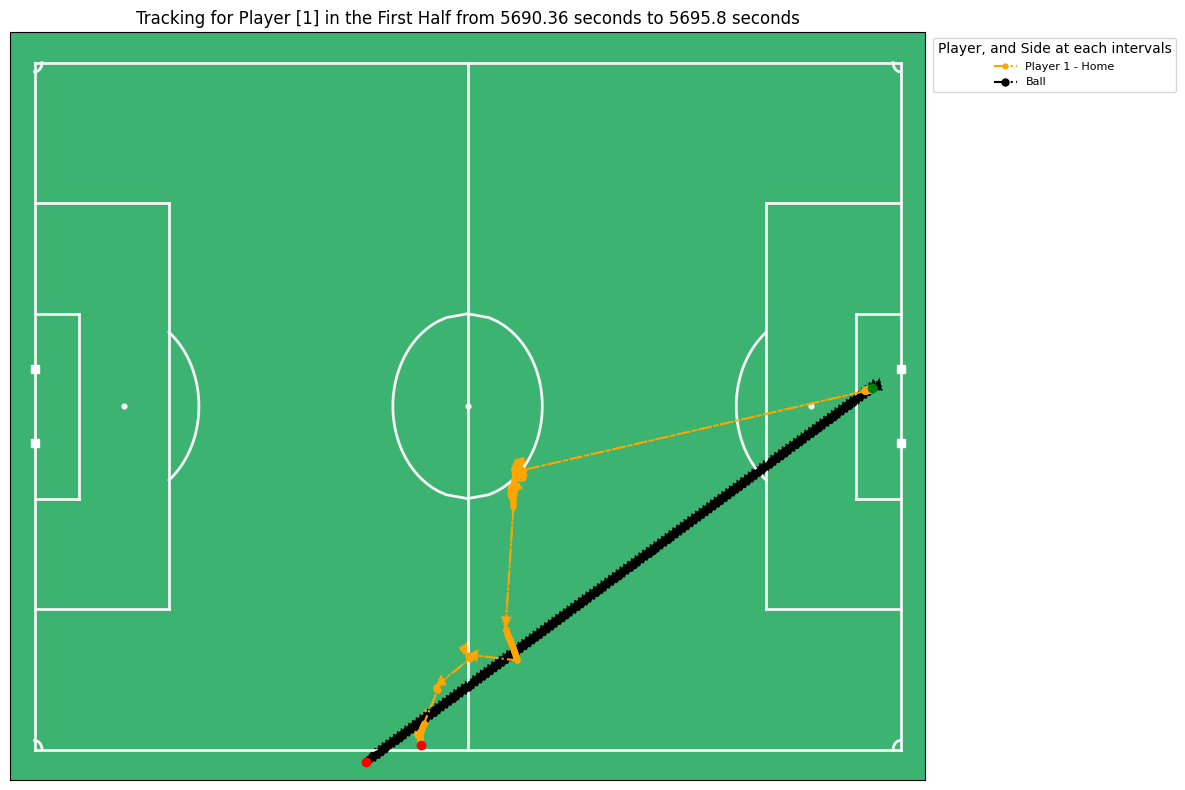

In [74]:
player_visualiz(smaller_dataset, plot_ball=True, players=[1], use_annotation=None, sides=["Home"]*1) # Putting down [0] and ["Home"] because we don't want it to be different color and it's easier

# Classification

In [25]:
game_1_event_data = pd.read_csv("data/Sample_Game_1/Sample_Game_1_RawEventsData.csv")
game_2_event_data = pd.read_csv("data/Sample_Game_2/Sample_Game_2_RawEventsData.csv")

game_1_event_data = game_1_event_data[~(game_1_event_data["Type"] == "FAULT RECEIVED")]
game_2_event_data = game_2_event_data[~(game_2_event_data["Type"] == "FAULT RECEIVED")]

game_1_event_data = game_1_event_data.replace("RECOVERY", "BALL LOST")
game_2_event_data = game_2_event_data.replace("RECOVERY", "BALL LOST")

In [26]:
game_1_event_data

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,1,0.04,0,0.00,Player19,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,1,0.04,3,0.12,Player19,Player21,0.45,0.39,0.55,0.43
2,Away,PASS,NaN,1,3,0.12,17,0.68,Player21,Player15,0.55,0.43,0.58,0.21
3,Away,PASS,NaN,1,45,1.80,61,2.44,Player15,Player19,0.55,0.19,0.45,0.31
4,Away,PASS,NaN,1,77,3.08,96,3.84,Player19,Player21,0.45,0.32,0.49,0.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1740,Home,PASS,NaN,2,143361,5734.44,143483,5739.32,Player12,Player13,0.60,0.33,0.19,0.95
1741,Home,PASS,NaN,2,143578,5743.12,143593,5743.72,Player13,Player4,0.09,0.88,0.14,0.69
1742,Home,BALL LOST,INTERCEPTION,2,143598,5743.92,143618,5744.72,Player4,NaN,0.13,0.69,0.07,0.61
1743,Away,BALL LOST,BLOCKED,2,143617,5744.68,143617,5744.68,Player16,NaN,0.05,0.62,NaN,NaN


In [27]:
game_2_event_data

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,51,2.04,51,2.04,Player23,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,51,2.04,87,3.48,Player23,Player20,0.50,0.50,0.40,0.51
2,Away,PASS,NaN,1,146,5.84,186,7.44,Player20,Player18,0.43,0.50,0.44,0.22
3,Away,PASS,NaN,1,248,9.92,283,11.32,Player18,Player17,0.47,0.19,0.31,0.28
4,Away,PASS,NaN,1,316,12.64,346,13.84,Player17,Player16,0.29,0.32,0.26,0.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1930,Away,BALL LOST,INTERCEPTION,2,140122,5604.88,140183,5607.32,Player21,NaN,0.54,0.77,0.29,0.24
1931,Home,CHALLENGE,AERIAL-LOST,2,140180,5607.20,140180,5607.20,Player1,NaN,0.31,0.30,NaN,NaN
1932,Away,CHALLENGE,AERIAL-LOST,2,140183,5607.32,140183,5607.32,Player24,NaN,0.32,0.30,NaN,NaN
1933,Home,BALL LOST,NaN,2,140211,5608.44,140211,5608.44,Player12,NaN,0.34,0.32,NaN,NaN


In [28]:
game_1_event_data = game_1_event_data[["Type", "Start Frame", "End Frame", "From", "To"]]
game_2_event_data = game_2_event_data[["Type", "Start Frame", "End Frame", "From", "To"]]

In [29]:
game_1_event_data

,Type,Start Frame,End Frame,From,To
0,SET PIECE,1,0,Player19,NaN
1,PASS,1,3,Player19,Player21
2,PASS,3,17,Player21,Player15
3,PASS,45,61,Player15,Player19
4,PASS,77,96,Player19,Player21
...,...,...,...,...,...
1740,PASS,143361,143483,Player12,Player13
1741,PASS,143578,143593,Player13,Player4
1742,BALL LOST,143598,143618,Player4,NaN
1743,BALL LOST,143617,143617,Player16,NaN


In [30]:
game_2_event_data

,Type,Start Frame,End Frame,From,To
0,SET PIECE,51,51,Player23,NaN
1,PASS,51,87,Player23,Player20
2,PASS,146,186,Player20,Player18
3,PASS,248,283,Player18,Player17
4,PASS,316,346,Player17,Player16
...,...,...,...,...,...
1930,BALL LOST,140122,140183,Player21,NaN
1931,CHALLENGE,140180,140180,Player1,NaN
1932,CHALLENGE,140183,140183,Player24,NaN
1933,BALL LOST,140211,140211,Player12,NaN


In [31]:
game_1_event = process_event_data(game_1_event_data, game_1_data)
game_2_event = process_event_data(game_2_event_data, game_2_data)

In [32]:
game_1_event

,Type
1,PASS
2,PASS
3,PASS
4,PASS
5,PASS
...,...
143626,BALL OUT
143627,BALL OUT
143628,BALL OUT
143629,BALL OUT


In [33]:
game_2_event

,Type
51,PASS
52,PASS
53,PASS
54,PASS
55,PASS
...,...
140294,BALL OUT
140295,BALL OUT
140296,BALL OUT
140297,BALL OUT


In [34]:
common_indices = game_1_event.index.intersection(game_1_min_dist_to_ball.index)
X_1 = game_1_min_dist_to_ball.loc[common_indices]
X_1 = X_1.iloc[:, 1:]
y_1 = game_1_event.loc[common_indices, "Type"]

In [35]:
common_indices = game_2_event.index.intersection(game_2_min_dist_to_ball.index)
X_2 = game_2_min_dist_to_ball.loc[common_indices]
X_2 = X_2.iloc[:, 1:]
y_2 = game_2_event.loc[common_indices, "Type"]

In [36]:
X_1

,P_1-x,P_2-x,P_3-x,P_4-x,P_5-x,P_1-y,P_2-y,P_3-y,P_4-y,P_5-y,Ball-x,Ball-y
1,0.45472,0.52697,0.39125,0.41698,0.55243,0.38709,0.37980,0.32550,0.47843,0.43269,0.45472,0.38709
45,0.54866,0.52154,0.43756,0.40832,0.44757,0.18903,0.26836,0.14605,0.26744,0.31626,0.54946,0.18931
77,0.45291,0.43778,0.50179,0.50317,0.41499,0.31772,0.29844,0.36924,0.24403,0.41190,0.45275,0.31666
279,0.38634,0.37040,0.35869,0.47727,0.25680,0.96182,0.95056,0.88086,0.95991,0.86654,0.38483,0.96216
346,0.50934,0.45743,0.43115,0.35385,0.56220,0.96737,0.92335,0.98656,0.92570,0.81457,0.50909,0.96777
...,...,...,...,...,...,...,...,...,...,...,...,...
143246,0.74039,0.69642,0.79766,0.73745,0.73818,0.21525,0.25094,0.25358,0.28955,0.31371,0.73956,0.21534
143247,0.74125,0.69783,0.79871,0.73815,0.73860,0.21516,0.24886,0.25240,0.28885,0.31251,0.74041,0.21525
143262,0.75339,0.72115,0.74582,0.81186,0.73955,0.21548,0.22455,0.27291,0.24096,0.29951,0.75271,0.21544
143263,0.75407,0.72281,0.74609,0.81251,0.73924,0.21549,0.22321,0.27156,0.24055,0.29886,0.75242,0.21682


In [37]:
np.unique(y_1, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'CARD', 'CHALLENGE', 'PASS', 'SET PIECE',
        'SHOT'], dtype=object),
 array([1005,   41,    4,   65, 1257,   12,    9], dtype=int64))

In [38]:
np.unique(y_2, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'CARD', 'CHALLENGE', 'PASS', 'SET PIECE',
        'SHOT'], dtype=object),
 array([ 675,  135,    6,   72, 1389,    9,   27], dtype=int64))

In [45]:
scaler = MinMaxScaler()
X_1_scaled = scaler.fit_transform(X_1)
X_2_scaled = scaler.transform(X_2)

In [46]:
label_encoder = LabelEncoder()
y_1_encoded = label_encoder.fit_transform(y_1)
y_2_encoded = label_encoder.transform(y_2)

In [56]:
print(X_1.shape)
print(X_2.shape)

(2393, 12)
(2313, 12)


In [57]:
X_1_scaled = X_1_scaled[:(X_1_scaled.shape[0] - X_1_scaled.shape[0] % 100)]
y_1_encoded = y_1_encoded[:(y_1_encoded.shape[0] - y_1_encoded.shape[0] % 100)]

X_2_scaled = X_2_scaled[:(X_2_scaled.shape[0] - X_2_scaled.shape[0] % 100)]
y_2_encoded = y_2_encoded[:(y_2_encoded.shape[0] - y_2_encoded.shape[0] % 100)]

In [58]:
print(X_1_scaled.shape)
print(X_2_scaled.shape)

(2300, 12)
(2300, 12)


In [103]:
# common_features = list(set(X_1.columns) & set(X_2.columns))
# X_1_common = X_1[common_features]
# X_2_common = X_2[common_features]

In [59]:
models = {
      # "AdaBoost classifier": AdaBoostClassifier(random_state=42), 
      # "Logistic regression": LogisticRegression(solver="saga", random_state=42),
      # "Gaussian naive bayes": GaussianNB(),
      "Random forest classifier": RandomForestClassifier(n_jobs=-1, n_estimators=162, max_features="log2",), 
      # "Neural network": MLPClassifier(hidden_layer_sizes=(32, 32, 32, 16, 16,), learning_rate="adaptive", random_state=42), 
    }

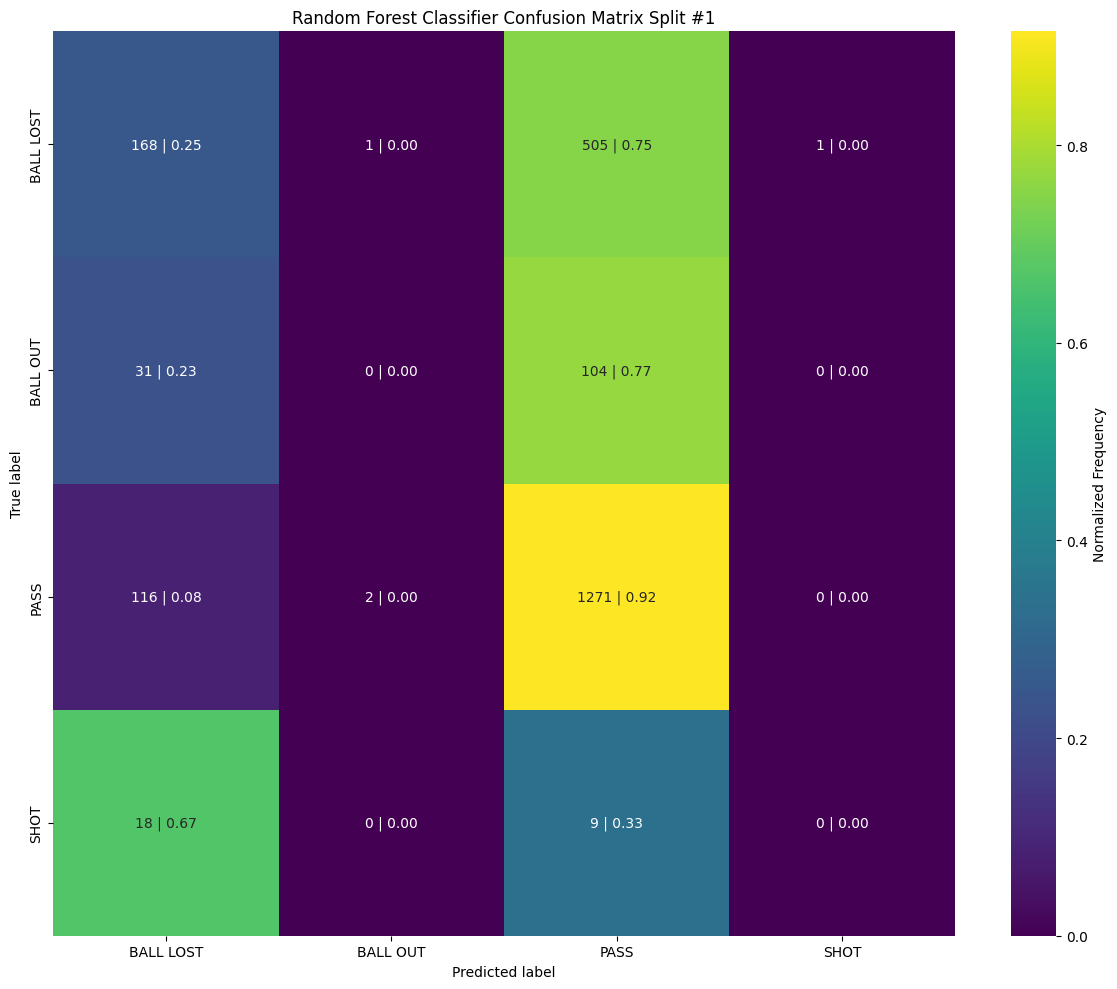

Random forest classifier training accuracy: 100.00%
Random forest classifier testing accuracy: 62.21%

Random forest classifier testing precision: 53.25%
Random forest classifier testing recall: 62.21%
Random forest classifier testing f1: 55.11%




In [49]:
# for i in range(len(scaled["X_train"])):
for name, model in models.items():
    # X_train_scaled = scaled["X_train"][0]
    # X_test_scaled = scaled["X_test"][0]
    # y_train = scaled["y_train"][0]
    # y_test = scaled["y_test"][0]

    model.fit(X_1, y_1)
    y_train_pred = model.predict(X_1)
    y_pred = model.predict(X_2)    
    labels = np.unique(['BALL LOST', 'BALL OUT', 'PASS', 'SHOT'])# np.unique(y_1)
    
    plot_confusion_matrix(y_train=y_1, y_train_pred=y_train_pred, y_test=y_2, y_pred=y_pred, labels=labels, split=0, model_name=name)
    
    # print("\n")

In [60]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    device_name = torch.cuda.get_device_name(device)
    print(f"Using {device}: {device_name}")
else:
    device = torch.device("cpu")
    print(f"Using {device} device")

Using cuda: NVIDIA GeForce RTX 3060 Laptop GPU


In [61]:
np.unique(y_1).shape, np.unique(y_2).shape

((7,), (7,))

In [72]:
lstm_params = {
    "input_size": X_1_scaled.shape[1],
    "hidden_size" : 256,
    "num_layers" : 2,
    "num_classes" : np.unique(y_1_encoded).shape[0],
    "dropout_rate": 0.10523009649860546,
}
input_size = X_1_scaled.shape[1]
sequence_length = 50
learning_rate = 0.0012682942484929386
batch_size = 256
num_epochs = 150

In [73]:
class CustomDataset(Dataset):
    def __init__(self, features, labels, sequence_task=True):
        self.features = torch.tensor(features.values if hasattr(features, "values") else features,
                                   dtype=torch.float32)
        self.labels = torch.tensor(labels.values if hasattr(labels, "values") else labels,
                                 dtype=torch.long)
        self.sequence_task = sequence_task
        
        # Validate shapes
        assert self.features.shape[0] == self.labels.shape[0], \
            f"Number of samples mismatch: features {self.features.shape[0]}, labels {self.labels.shape[0]}"
        
        if sequence_task:
            assert self.features.shape[1] == self.labels.shape[1], \
                f"Sequence length mismatch: features {self.features.shape[1]}, labels {self.labels.shape[1]}"
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# X_comb = np.concatenate([X_1_scaled, X_2_scaled])
# y_comb = np.concatenate((y_1_encoded, y_2_encoded))

X_1_reshaped = X_1_scaled.reshape(-1, sequence_length, input_size)
y_1_reshaped = y_1_encoded.reshape(-1, sequence_length)

X_2_reshaped = X_2_scaled.reshape(-1, sequence_length, input_size)
y_2_reshaped = y_2_encoded.reshape(-1, sequence_length) 

training_dataset = CustomDataset(X_1_reshaped, y_1_reshaped)
validation_dataset = CustomDataset(X_2_reshaped, y_2_reshaped)

train_loader = DataLoader(
    dataset=training_dataset, 
    batch_size=batch_size, 
    shuffle=False,
)

validation_loader = DataLoader(
    dataset=validation_dataset, 
    batch_size=batch_size, 
    shuffle=False,
)

In [74]:
lstm_model = get_model("lstm", lstm_params=lstm_params).to(device)
lstm_model

LSTM(
  (input_bn): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder): LSTM(12, 256, num_layers=2, batch_first=True)
  (decoder): LSTM(7, 256, num_layers=2, batch_first=True)
  (hidden_bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.10523009649860546, inplace=False)
    (4): Linear(in_features=256, out_features=7, bias=True)
  )
)

In [75]:
acc = train_model(lstm_model, train_loader, validation_loader, num_epochs, "adam", nn.CrossEntropyLoss(), learning_rate, device, is_seq_model=True)

Epoch 1/150: Train accuracy: 6.83% | Val accuracy: 3.04% | Train loss: 2.4738 | Val loss: 1.9860 | learning rate: 0.001268 | Precision: 0.09% | Recall: 3.04% | F1: 0.18%
Epoch 2/150: Train accuracy: 6.22% | Val accuracy: 3.52% | Train loss: 2.6150 | Val loss: 15.2458 | learning rate: 0.001268 | Precision: 50.80% | Recall: 3.52% | F1: 4.66%
Epoch 3/150: Train accuracy: 10.04% | Val accuracy: 5.57% | Train loss: 2.4056 | Val loss: 9.8950 | learning rate: 0.001268 | Precision: 51.41% | Recall: 5.57% | F1: 8.12%
Epoch 4/150: Train accuracy: 27.39% | Val accuracy: 15.52% | Train loss: 2.2165 | Val loss: 3.6804 | learning rate: 0.001268 | Precision: 8.98% | Recall: 15.52% | F1: 11.32%
Epoch 5/150: Train accuracy: 31.65% | Val accuracy: 17.09% | Train loss: 1.8987 | Val loss: 3.9544 | learning rate: 0.001268 | Precision: 50.21% | Recall: 17.09% | F1: 13.69%
Epoch 6/150: Train accuracy: 41.17% | Val accuracy: 22.91% | Train loss: 1.7284 | Val loss: 1.8728 | learning rate: 0.001268 | Precision:

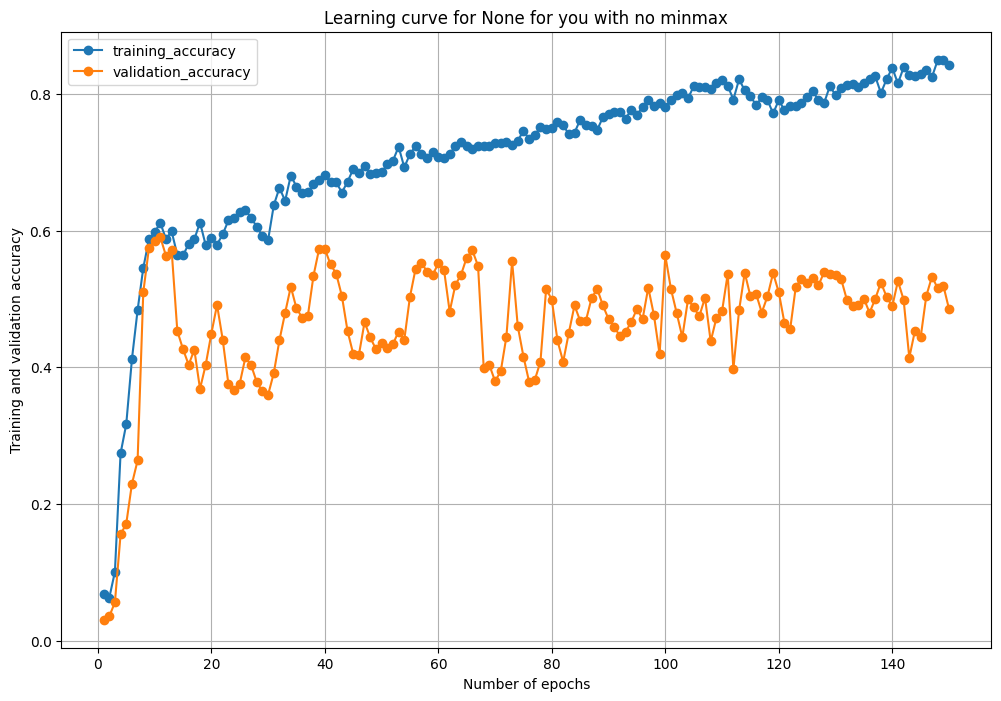

In [76]:
plot_accuracy_history(acc, title="None for you with no minmax")